In [154]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [155]:
import os
def getHistory(season, current_season):
    gw = pd.DataFrame()
    PATH = "C:\\Users\\mvellera\\Documents\\GitHub\\Fantasy-Premier-League\\data\\" + season + "\\gws\\"
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if '.csv' in file:
                if(file != 'merged_gw.csv'):
                    files.append(os.path.join(r, file))

    for f in files:
        temp = pd.read_csv(f, encoding="latin-1")    
        temp['gw'] = f.split('\\')[-1].split('.')[0][2:]
        temp['season'] = season 
        gw = gw.append(temp, ignore_index=True)

    gw['kickoff_time'] = pd.to_datetime(gw['kickoff_time'])
    gw['date'] = pd.to_datetime(gw['kickoff_time']).dt.date

    if int(season.split('-')[0]) > 2018:
        teams = pd.read_csv('C:/Users/mvellera/Documents/GitHub/Fantasy-Premier-League/data/' + season + '/teams.csv', encoding="latin-1")
        teams = teams[['id', 'short_name']]
        gw = pd.merge(gw, teams, 'left', left_on='opponent_team', right_on = 'id')
        gw.drop(['id', 'opponent_team'], axis = 1, inplace = True)
        gw.rename(columns = {'short_name': 'opponent_team_name'}, inplace = True)
        
        players = pd.read_csv('C:\\Users\\mvellera\\Documents\\GitHub\\Fantasy-Premier-League\\data\\' + season + '\\players_raw.csv', encoding="latin-1")        
        squad = players[['first_name', 'second_name', 'element_type', 'id', 'team', 'now_cost', 'code']]
        gw = pd.merge(gw, squad, 'left', left_on = "element", right_on='id')
        gw = pd.merge(gw, teams, 'left', left_on = 'team', right_on ='id')
        gw.drop(['team', 'id_y'], axis = 1, inplace =  True)
        gw = gw.rename(columns = {'short_name': 'team_name',
                                  'id_x': 'id'})
        di = {1: "GK", 2: "DEF", 3: "MID", 4: "FWD"}
        gw['new_position'] = gw['element_type'].map(di)
        gw.drop('element_type', axis = 1, inplace = True)
        gw['name'] = gw['first_name'] +  ' ' + gw['second_name']
        gw = gw[~(gw['minutes'] == 0)]
    else:
        teams = pd.read_csv('C:/Users/mvellera/Documents/Personal/Projects/FPL/teams' + season.replace('-', '') + '.csv', encoding="latin-1")
        players = pd.read_csv('C:\\Users\\mvellera\\Documents\\GitHub\\Fantasy-Premier-League\\data\\' + season + '\\players_raw.csv', encoding="latin-1")
        squad = players[['first_name', 'second_name', 'element_type', 'id', 'team', 'code']]
        gw = pd.merge(gw, teams, 'left', on ='opponent_team')
        gw = pd.merge(gw, squad, 'left', left_on = "element", right_on='id')
        gw = pd.merge(gw, teams, 'left', left_on = 'team', right_on ='opponent_team')
        gw.drop(['opponent_team_y', 'id_y'], axis = 1, inplace =  True)
        gw = gw.rename(columns = {'opponent_team_name_x': 'opponent_team_name', 
                                  'opponent_team_name_y': 'team_name',
                                  'id_x': 'id'})
        
        di = {1: "GK", 2: "DEF", 3: "MID", 4: "FWD"}
        gw['old_position'] = gw['element_type'].map(di)
        gw.drop('element_type', axis = 1, inplace = True)
        players2019 = pd.read_csv('C:\\Users\\mvellera\\Documents\\GitHub\\Fantasy-Premier-League\\data\\' + current_season + '\\players_raw.csv', encoding='latin-1')
        squad2019 = players2019[['first_name', 'second_name', 'element_type', 'now_cost', 'code']]
        gw = pd.merge(gw, squad2019, 'left', on = 'code', suffixes = ('', '_y'))
        gw['new_position'] = gw['element_type'].map(di)
        gw.drop(['element_type', 'first_name_y', 'second_name_y'], axis = 1, inplace = True)
        gw['name'] = gw['first_name'] +  ' ' + gw['second_name']
        gw = gw[~(gw['now_cost'].isnull())]
        gw = gw[~(gw['minutes'] == 0)]

        condition = (gw.old_position == 'MID') & (gw.new_position == 'FWD')
        gw.loc[condition, 'total_points'] = gw.loc[condition, 'total_points'] - gw.loc[condition, 'goals_scored'] - gw.loc[condition, 'clean_sheets']

        condition = (gw.old_position == 'FWD') & (gw.new_position == 'MID')
        gw.loc[condition, 'total_points'] = gw.loc[condition, 'total_points'] + gw.loc[condition, 'goals_scored'] + gw.loc[condition, 'clean_sheets']

        condition = (gw.old_position == 'MID') & (gw.new_position == 'DEF')
        gw.loc[condition, 'total_points'] = gw.loc[condition, 'total_points'] + gw.loc[condition, 'goals_scored'] + 4*gw.loc[condition, 'clean_sheets']

        condition = (gw.old_position == 'DEF') & (gw.new_position == 'MID')
        gw.loc[condition, 'total_points'] = gw.loc[condition, 'total_points'] - gw.loc[condition, 'goals_scored'] - 4*gw.loc[condition, 'clean_sheets']
    
    #print(gw.head(1))
    gw = gw[['kickoff_time', 'season', 'gw', 'name', 'team_name', 'opponent_team_name', 'team_h_score', 'team_a_score', 'new_position', 'total_points', 'minutes', 'bonus', 
             'goals_scored', 'goals_conceded', 'assists', 'was_home', 'yellow_cards', 'red_cards', 'saves', 
             'threat', 'ict_index', 'clean_sheets', 'now_cost', 'code']]
    return gw

In [156]:
gw2016 = getHistory(season = "2016-17", current_season = "2019-20")
gw2017 = getHistory(season = "2017-18", current_season = "2019-20")
gw2018 = getHistory(season = "2018-19", current_season = "2019-20")
gw2019 = getHistory(season = "2019-20", current_season = "2019-20")

In [157]:
gw2016.shape, gw2017.shape, gw2018.shape, gw2019.shape

((5664, 24), (7245, 24), (8592, 24), (3585, 24))

In [158]:
gw = pd.concat((gw2016, gw2017, gw2018, gw2019))
gw['gw'] = gw['gw'].astype('int')
gw = gw.sort_values(['season', 'gw'], ascending = True)
gw_original = gw

In [159]:
def points_adj_linear(group):
    group = group.sort_values(['season', 'gw']).reset_index(drop = True)
    group['total_points_adj'] = group['total_points'] * ((group.index.values + 1)/(len(group)))
    group['minutes_adj'] = group['minutes'] * ((group.index.values + 1)/(len(group)))
    return group

In [160]:
def points_adj_exp_decay(group):
    group = group.sort_values(['season', 'gw'], ascending = [False, False]).reset_index(drop = True)
    t = np.linspace(1, len(group), len(group))  
    tau = n
    factor = np.exp(-t/tau)
    group['total_points_adj'] = group['total_points'] * factor
    group['minutes_adj'] = group['minutes'] * factor
    return group

In [161]:
def points_adj_exp_decay_2(group, multiply_factor):
    group = group.sort_values(['season', 'gw'], ascending = [False, False]).reset_index(drop = True)
    N = 1
    factor = []
    for i in range(0, len(group)):
        N = N * np.exp(-i*multiply_factor)
        factor.append(N)
    group['total_points_adj'] = group['total_points'] * factor
    group['minutes_adj'] = group['minutes'] * factor
    return group

In [162]:
def points_adj_exp_decay_3(group):
    group = group.sort_values(['season', 'gw'], ascending = [False, False]).reset_index(drop = True)
    tmax = 121
    tau = tmax/7
    t = np.linspace(1, tmax, tmax)
    factor = np.exp(-t/tau)[0:len(group)]
    group['total_points_adj'] = group['total_points'] * factor
    group['minutes_adj'] = group['minutes'] * factor
    return group

In [163]:
def fixture_decay(group, multiply_factor):
    group = group.sort_values(['season', 'gw'], ascending = [False, False]).reset_index(drop = True)
    N = 1
    factor = []
    for i in range(0, len(group)):
        N = N * np.exp(-i*multiply_factor)
        factor.append(N)
    group['team_h_score_adj'] = group['team_h_score'] * factor
    group['team_a_score_adj'] = group['team_a_score'] * factor
    group['minutes_adj'] = group['minutes'] * factor
    return group

In [206]:
#Initialize weights
def getPPM(player_points_decay, fixture_difficulty_decay, fixture_clusters, max_gw, next_fixture_count):
    gw = gw_original
    current_season = str(gw.season.str.split('-').str[0].astype('int').drop_duplicates().nlargest()[0:1].values[0])
    #max_gw = gw[(gw.season.str.split('-').str[0] == current_season)].gw.max()
    gw = gw[((gw.season.str.split('-').str[0] == current_season) & (gw['gw'] <= max_gw)) | (gw.season.str.split('-').str[0] != current_season)]
    last_gw_kickoff = gw[(gw.season.str.split('-').str[0] == current_season) & (gw['gw'] == max_gw)].kickoff_time.max()

    #Adjust points with an exponential decay function
    gw = gw.groupby('name').apply(lambda x: points_adj_exp_decay_2(x, player_points_decay)).reset_index(drop = True)

    #Get Current Teams
    current_teams = gw[(gw.season.str.split('-').str[0] == str(gw.season.str.split('-').str[0].astype('int')\
                                                              .drop_duplicates().nlargest()[0:1].values[0]))].team_name.unique()

    #Get Fixture Difficulty
    fixture_difficulty = gw.drop_duplicates(['season', 'team_name', 'opponent_team_name', 'was_home'])
    fixture_difficulty = fixture_difficulty[['season', 'gw', 'team_name', 'opponent_team_name', 
                                             'team_h_score', 'team_a_score', 'was_home']]
    fixture_difficulty['minutes'] = 90
    #fixture_difficulty = fixture_difficulty[fixture_difficulty['team_name'].isin(current_teams) & fixture_difficulty['opponent_team_name'].isin(current_teams)]

    fixture_difficulty = fixture_difficulty.groupby('team_name').apply(lambda x: fixture_decay(x, fixture_difficulty_decay)).reset_index(drop = True)

    fixture_difficulty.loc[:,'goals_scored_adj'] = np.where(fixture_difficulty['was_home'] == True, 
                                                               fixture_difficulty['team_h_score_adj'],
                                                               fixture_difficulty['team_a_score_adj'])

    fixture_difficulty.loc[:,'goals_conceded_adj'] = np.where(fixture_difficulty['was_home'] == False, 
                                                               fixture_difficulty['team_h_score_adj'],
                                                               fixture_difficulty['team_a_score_adj'])

    fixture_difficulty = fixture_difficulty.groupby(['team_name', 'was_home']).agg({'goals_scored_adj': 'sum',
                                                                                  'goals_conceded_adj': 'sum',
                                                                                  'minutes_adj': 'sum'}).reset_index()

    fixture_difficulty['goals_scored_adj_per_minute'] = fixture_difficulty['goals_scored_adj'] / fixture_difficulty['minutes_adj']
    fixture_difficulty['goals_conceded_adj_per_minute'] = fixture_difficulty['goals_conceded_adj'] / fixture_difficulty['minutes_adj']

    fixture_difficulty = fixture_difficulty[['team_name', 'was_home', 'goals_scored_adj_per_minute', 'goals_conceded_adj_per_minute']]

    data = pd.get_dummies(fixture_difficulty, columns = ['was_home'], drop_first = True)
    X = data[['goals_scored_adj_per_minute', 'goals_conceded_adj_per_minute', 'was_home_True']].values
    
    from sklearn.cluster import KMeans
    def get_clusters(X, nClusters):
        kmeans = KMeans(n_clusters = nClusters, random_state=0).fit(X)
        return kmeans.labels_

    fixture_difficulty['cluster'] = get_clusters(X, fixture_clusters)
    fixture_difficulty.rename(columns={'cluster': 'fixture_difficulty'}, inplace=True)
    #print(fixture_difficulty.sort_values('goals_conceded_adj_per_minute', ascending = True))
    gw['opposition_was_home'] = ~gw['was_home']


    gw = pd.merge(gw, fixture_difficulty, left_on = ['opponent_team_name', 'opposition_was_home'], right_on = ['team_name', 'was_home'])
    gw.rename(columns={'team_name_x': 'team_name'}, inplace=True)
    gw.drop('team_name_y', axis=1,inplace=True)

    most_points = gw.groupby(['season', 'team_name', 'new_position', 'name', 'fixture_difficulty']).agg({
                                                                    'total_points': 'sum', 
                                                                    'total_points_adj': 'sum', 
                                                                    'minutes': 'sum', 
                                                                    'minutes_adj': 'sum', 
                                                                    'bonus': 'sum',
                                                                    'goals_scored': 'sum',
                                                                    'assists': 'sum',
                                                                    'threat': 'sum',
                                                                    'ict_index': 'sum',                                                                
                                                                    'clean_sheets': 'sum',
                                                                    'now_cost': 'max'
                                                                    }).sort_values('total_points_adj', ascending = False).reset_index()

    most_points['90count'] = (most_points['minutes']/90).round().astype('int')

    overall_games = most_points.groupby(['team_name', 'new_position', 'name']).agg({'minutes': 'sum'}).reset_index()
    overall_games['overall_90count'] = (overall_games['minutes']/90).round().astype('int')
    overall_games = overall_games.drop('minutes', axis=1)

    most_points = pd.merge(most_points, overall_games, on = ['team_name', 'new_position', 'name'])

    season_games = most_points.groupby(['season', 'team_name', 'new_position', 'name']).agg({'minutes': 'sum'}).reset_index()
    season_games['season_90count'] = (season_games['minutes']/90).round().astype('int')
    season_games = season_games.drop('minutes', axis=1)

    most_points = pd.merge(most_points, season_games, on = ['season', 'team_name', 'new_position', 'name'])

    most_points = most_points[most_points.name.isin(

                    most_points[
                   ((most_points.season.str.split('-').str[0] == str(most_points.season.str.split('-').str[0].astype('int')\
                                                              .drop_duplicates().nlargest()[0:1].values[0]))
                      & (most_points['season_90count'] >= max_gw/1.5))
                   |

                   ((most_points.season.str.split('-').str[0] == str(most_points.season.str.split('-').str[0].astype('int')\
                                                              .drop_duplicates().nlargest()[0:1].values[0]))
                      & (most_points['season_90count'] >= max_gw/1.5))

                   &(((most_points.season.str.split('-').str[0] == str(most_points.season.str.split('-').str[0].astype('int')\
                                                              .drop_duplicates().nlargest()[1:2].values[0]))
                      & (most_points['season_90count'] > 24))
                   |(most_points['overall_90count'] > 38))]['name'].drop_duplicates())]

    most_points = most_points.groupby(['new_position', 'name', 'fixture_difficulty']).agg({
                                                                    'total_points': 'sum', 
                                                                    'total_points_adj': 'sum', 
                                                                    'minutes': 'sum', 
                                                                    'minutes_adj': 'sum', 
                                                                    'bonus': 'sum',
                                                                    'goals_scored': 'sum',
                                                                    'assists': 'sum',                                                        
                                                                    'clean_sheets': 'sum', 
                                                                    'now_cost': 'max'
                                                                    }).sort_values('total_points_adj', ascending = False).reset_index()

    most_points = pd.merge(most_points, gw2019[['name', 'team_name']].drop_duplicates(), on = 'name')

    most_points['ppm90'] = ((most_points.total_points_adj/most_points.minutes_adj)*90)
    most_points['90count'] = (most_points['minutes']/90).round().astype('int')
    most_points['bonus90'] = ((most_points['bonus']/most_points.minutes)*90).round(1)
    most_points['now_cost'] = most_points['now_cost']/10
    
    ppm = most_points.sort_values('ppm90', ascending=False).reset_index(drop = True)
    ppm = ppm[ppm['90count'] > 1]
    

    fixtures2019 = pd.read_csv('C:\\Users\\mvellera\\Documents\\GitHub\\Fantasy-Premier-League\\data\\' + '2019-20' + '\\fixtures.csv', encoding='latin-1')
    teams2019 = pd.read_csv('C:\\Users\\mvellera\\Documents\\GitHub\\Fantasy-Premier-League\\data\\' + '2019-20' + '\\teams.csv', encoding='latin-1')

    fixtures2019['kickoff_time'] = pd.to_datetime(fixtures2019['kickoff_time'])
    fixtures2019 = fixtures2019[(fixtures2019['kickoff_time'] > last_gw_kickoff) & ~(fixtures2019['kickoff_time'].isnull())]
    fixtures2019 = fixtures2019[['kickoff_time', 'team_a', 'team_a_difficulty', 'team_h', 'team_h_difficulty']]

    fixtures2019 = pd.merge(fixtures2019, teams2019[['id', 'short_name']], left_on = 'team_a', right_on = 'id')
    fixtures2019 = pd.merge(fixtures2019, teams2019[['id', 'short_name']], left_on = 'team_h', right_on = 'id')

    fixtures2019.rename(columns={'short_name_x': 'team_a_name', 
                         'short_name_y': 'team_h_name'}, inplace = True)
    fixtures2019.drop(['id_x', 'id_y'], axis = 1, inplace = True)
    fixtures2019 = fixtures2019.sort_values('kickoff_time')

    next_fixtures = pd.DataFrame()
    for team in current_teams:
        fixtures = fixtures2019[(fixtures2019['team_a_name'] == team) | (fixtures2019['team_h_name'] == team)].head(next_fixture_count)
        fixtures.loc[:,'was_home'] = np.where(fixtures['team_h_name'] == team, True, False)
        fixtures['opposition_was_home'] = ~fixtures['was_home']
        fixtures['team_name'] = np.where(fixtures['was_home'] == True, fixtures['team_h_name'], fixtures['team_a_name'])
        fixtures['opponent_team_name'] =  np.where(fixtures['was_home'] == True, fixtures['team_a_name'], fixtures['team_h_name'])

        fixtures = fixtures[['team_name', 'opponent_team_name', 'was_home', 'opposition_was_home']]
        fixtures = pd.merge(fixtures, fixture_difficulty[['team_name', 'was_home', 'fixture_difficulty']], left_on = ['opponent_team_name', 'opposition_was_home'], right_on = ['team_name', 'was_home'])

        fixtures.drop(['team_name_y', 'was_home_y'], axis = 1, inplace = True)
        fixtures.rename(columns={'team_name_x': 'team_name', 'was_home_x': 'was_home'}, inplace = True)

        next_fixtures = next_fixtures.append(fixtures)

    ppm_next_fixtures = pd.merge(next_fixtures, ppm, on = ['team_name', 'fixture_difficulty'])
    ppm = ppm_next_fixtures.groupby(['new_position', 'team_name', 'name']).agg({
                                                                'total_points': 'sum', 
                                                                'total_points_adj': 'sum', 
                                                                'minutes': 'sum', 
                                                                'minutes_adj': 'sum', 
                                                                'bonus': 'sum',
                                                                'goals_scored': 'sum',
                                                                'assists': 'sum',                                                              
                                                                'clean_sheets': 'sum', 
                                                                'ppm90': 'sum',
                                                                '90count': 'sum',
                                                                'now_cost': 'max'
                                                                }).sort_values('total_points_adj', ascending = False).reset_index()

    ppm = ppm.sort_values('ppm90', ascending = False).reset_index()
    
#     ppm = ppm[~(ppm.name.isin(['Lucas Digne', 'Bernardo Mota Veiga de Carvalho e Silva', 
#                                'Jack O\'Connell', 'Ben Foster', 'Lukasz Fabianski', 'Adama TraorÃ©', 
#                                'Ryan Fredericks', 'Richarlison de Andrade', 'Jordan Pickford', 'Seamus Coleman',
#                                'Nathan AkÃ©', 'Bernd Leno', 'Craig Cathcart'
#                            ]))].reset_index(drop = True)

#     ppm = ppm[~(ppm.name.isin(['Oleksandr Zinchenko', 'Sergio AgÃ¼ero', 'NicolÃ¡s Otamendi', 
#                                'Ayoze PÃ©rez', 'Marcos Alonso'
#                            ]))].reset_index(drop = True)

#     ppm = ppm[~(ppm.name.isin(['Kieran Trippier', 
#                                'Danilo Luiz da Silva',
#                                'Ruben Loftus-Cheek', 'John Lundstram', 'Todd Cantwell',
#                                'Leroy SanÃ©', 'Aymeric Laporte', 'Laurent Koscielny',
#                                'Gabriel Fernando de Jesus',
#                                'Divock Origi', 'Phil Jagielka',
#                                'Phil Foden', 'Wes Morgan', 'Jonjo Shelvey', 'Ademola Lookman',
#                                'Lys Mousset', 'Lukasz Fabianski',
#                                'Junior Stanislas', 'Dean Henderson',
#                                'Vicente Guaita', 'Erik Lamela',
#                                'Hugo Lloris', 'Lucas Digne', 'Oleksandr Zinchenko'
#                                ]))].reset_index(drop = True)

    ppm = ppm[ppm.total_points_adj > 3].reset_index(drop = True)
    return ppm, next_fixtures

In [207]:
# inertia = []
# K = range(2,39)
# for k in K:
#     km = KMeans(n_clusters=k, random_state=0).fit(X)
#     inertia.append(km.inertia_)

# elbow = pd.DataFrame()
# elbow['k'] = range(2,39)
# elbow['inertia'] = inertia

# plt.figure()
# plt.plot(elbow['k'], elbow['inertia'])
# plt.xlabel("Number of cluster")
# plt.ylabel("SSE")
# plt.show()

In [208]:
# ppm.loc[ppm.name.str.contains('Raheem Sterling'), 'now_cost'] = 12.
# ppm.loc[ppm.name.str.contains('Sadio ManÃ©'), 'now_cost'] = 11.5
# ppm.loc[ppm.name.str.contains('Sergio AgÃ¼ero'), 'now_cost'] = 12.
# ppm.loc[ppm.name.str.contains('Mount'), 'now_cost'] = 6.5 
# ppm.loc[ppm.name.str.contains('Pukki'), 'now_cost'] = 6.7
# ppm.loc[ppm.name.str.contains('Tammy Abraham'), 'now_cost'] = 7.1
# ppm.loc[ppm.name.str.contains('Pope'), 'now_cost'] = 4.5
# ppm.loc[ppm.name.str.contains('Trent'), 'now_cost'] = 7.2

In [209]:
from pulp import *
import re
import copy
def getOptimalTeam(ppm, metric, def_cnt, mid_cnt, fwd_cnt, player_exclusions):
#     print('\n' + str(def_cnt) + str(mid_cnt) + str(fwd_cnt))

    ppm = ppm[~(ppm.name.isin(player_exclusions))].reset_index(drop = True)
    formation = str(def_cnt) + str(mid_cnt) + str(fwd_cnt)
    problem_str = 'FantasyTeam' + str(def_cnt) + str(mid_cnt) + str(fwd_cnt) + str(metric)
    prob = pulp.LpProblem(problem_str, pulp.LpMaximize)
    decision_variables = []
    for rownum, row in ppm.iterrows():
        variable = str('x' + str(rownum))
        variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
        decision_variables.append(variable)

#    print ("Total number of decision_variables: " + str(len(decision_variables)))

    optim_fn = ""
    for rownum, row in ppm.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                formula = row[metric]*player
                optim_fn += formula

    prob += optim_fn
    
    if((formation == '532') | (formation == '541')):
        avail_cash = 81.4
        #avail_cash = 82.5
        #avail_cash = 82.4
        #avail_cash = 81.9
    else:
        avail_cash = 81.1
        #avail_cash = 83.
        #avail_cash = 82.9
        #avail_cash = 82.4
    total_paid = ""
    for rownum, row in ppm.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                formula = row['now_cost']*player
                total_paid += formula

    prob += (total_paid <= avail_cash)

    avail_gk = 1
    total_gk = ""
    for rownum, row in ppm.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['new_position'] == 'GK':
                    formula = 1*player
                    total_gk += formula
    prob += (total_gk == avail_gk)

    total_def = ""
    for rownum, row in ppm.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['new_position'] == 'DEF':
                    formula = 1*player
                    total_def += formula
    prob += total_def == def_cnt

    total_mid = ""
    for rownum, row in ppm.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['new_position'] == 'MID':
                    formula = 1*player
                    total_mid += formula
    prob += total_mid == mid_cnt

    total_fwd = ""
    for rownum, row in ppm.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['new_position'] == 'FWD':
                    formula = 1*player
                    total_fwd += formula
    prob += total_fwd == fwd_cnt

    team_dict= {}
    for team in set(ppm.team_name):
        team_dict[str(team)]=dict()
        team_dict[str(team)]['avail'] = 3
        team_dict[str(team)]['total'] = ""
        for rownum, row in ppm.iterrows():
            for i, player in enumerate(decision_variables):
                if rownum == i:
                    if row['team_name'] == team:
                        formula = 1*player
                        team_dict[str(team)]['total'] += formula

        prob += (team_dict[str(team)]['total'] <= team_dict[str(team)]['avail'])
 #   print(prob)

    prob.writeLP(problem_str + '.lp')
    optimization_result = prob.solve()
    assert optimization_result == pulp.LpStatusOptimal
#     print("Status:", LpStatus[prob.status])
#     print("Optimal Solution to the problem: ", pulp.value(prob.objective))
#     print ("Individual decision_variables: ")
#     for v in prob.variables():
#         print(v.name, "=", v.varValue)

    variable_name = []
    variable_value = []

    for v in prob.variables():
        variable_name.append(v.name)
        variable_value.append(v.varValue)

    df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
    for rownum, row in df.iterrows():
        value = re.findall(r'(\d+)', row['variable'])
        df.loc[rownum, 'variable'] = int(value[0])

    df = df.sort_index(by='variable')

    #append results
    for rownum, row in ppm.iterrows():
        for results_rownum, results_row in df.iterrows():
            if rownum == results_row['variable']:
                ppm.loc[rownum, 'decision'] = results_row['value']

#     print(ppm[ppm.decision==1].now_cost.sum()) # Returns 830
#     print(ppm[ppm.decision==1][metric].sum()) # Returns 2010.8606251232461

    return (ppm, ppm[ppm.decision==1][metric].sum())

In [212]:
# iterations = pd.DataFrame(columns = ['player_points_decay', 'fixture_difficulty_decay', 'fixture_clusters', 'max_gw', 'score'])
# for player_points_decay in np.linspace(0.007, 0.01, 4):
#     for fixture_difficulty_decay in np.linspace(0.001, 0.01, 10):
#         for fixture_clusters in [5]:
#             for max_gw in [5, 6, 7, 8, 9, 10, 11, 12]:
#                 ppm, next_fixtures = getPPM(player_points_decay, fixture_difficulty_decay, fixture_clusters, max_gw, 1)
#                 player_exclusions = []
                
#                 while True:
#                     ppm442, result442 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 4, mid_cnt = 4, fwd_cnt = 2,
#                                                        player_exclusions = player_exclusions)
#                     ppm352, result352 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 3, mid_cnt = 5, fwd_cnt = 2,
#                                                        player_exclusions = player_exclusions)
#                     ppm532, result532 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 5, mid_cnt = 3, fwd_cnt = 2,
#                                                        player_exclusions = player_exclusions)
#                     ppm343, result343 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 3, mid_cnt = 4, fwd_cnt = 3,
#                                                        player_exclusions = player_exclusions)
#                     ppm433, result433 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 4, mid_cnt = 3, fwd_cnt = 3,
#                                                        player_exclusions = player_exclusions)
#                     ppm451, result451 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 4, mid_cnt = 5, fwd_cnt = 1,
#                                                        player_exclusions = player_exclusions)
#                     ppm541, result541 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
#                                                        def_cnt = 5, mid_cnt = 4, fwd_cnt = 1,
#                                                        player_exclusions = player_exclusions)

#                     ppm_scores = pd.DataFrame()
#                     ppm_scores['formation'] = ['442', '352', '532', '343', '433', '451', '541']
#                     ppm_scores['scores'] = [result442, result352, result532, result343, result433, result451, result541]
#                     best_formation = ppm_scores.sort_values('scores', ascending = False).head(1).formation.values[0]
#                     if best_formation == '442':
#                         best_ppm = ppm442[ppm442.decision==1]
#                     if best_formation == '352':
#                         best_ppm = ppm352[ppm352.decision==1]
#                     if best_formation == '532':
#                         best_ppm = ppm532[ppm532.decision==1]
#                     if best_formation == '343':
#                         best_ppm = ppm343[ppm343.decision==1]
#                     if best_formation == '433':
#                         best_ppm = ppm433[ppm433.decision==1]
#                     if best_formation == '451':
#                         best_ppm = ppm451[ppm451.decision==1]
#                     if best_formation == '541':
#                         best_ppm = ppm541[ppm541.decision==1]   

#                     actuals = pd.merge(best_ppm, 
#                                        gw_original[(gw_original.season.str.split('-').str[0] == current_season) & (gw_original['gw'] == max_gw + 1)][['name', 'total_points', 'minutes']], 
#                                        on = 'name',
#                                        how = 'left')
#                     minutes0_players = list(actuals[actuals['minutes_y'].isnull()].name.unique())
#                     if(len(minutes0_players) == 0):
#                         break
#                     player_exclusions = player_exclusions + minutes0_players
#                     print("GW: " + str(max_gw + 1) + "\nPlayer Exclusions: " + str(player_exclusions))

#                 iterations = iterations.append({'player_points_decay': player_points_decay, 
#                                                 'fixture_difficulty_decay': fixture_difficulty_decay,
#                                                 'fixture_clusters': fixture_clusters,
#                                                 'max_gw': max_gw,
#                                                 'score': actuals.total_points_y.sum()}, ignore_index=True)

#                 iter_len = len(iterations)
#                 print(iter_len)
                
#                 if iter_len % 10 == 0:
#                     try:
#                         iterations.to_csv("Iterations_5Clusters_Remaining.csv", index=False)
#                     except:
#                         pass

In [220]:
iterations = pd.DataFrame(columns = ['player_points_decay', 'fixture_difficulty_decay', 'fixture_clusters', 'max_gw', 'score'])
for player_points_decay in np.linspace(0.015, 0.018, 4):
    for fixture_difficulty_decay in np.linspace(0.002, 0.005, 4):
        for fixture_clusters in [6]:
            for max_gw in [5, 6, 7, 8, 9, 10, 11, 12]:
                ppm, next_fixtures = getPPM(player_points_decay, fixture_difficulty_decay, fixture_clusters, max_gw, 1)
                player_exclusions = []
                
                while True:
                    ppm442, result442 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 4, mid_cnt = 4, fwd_cnt = 2,
                                                       player_exclusions = player_exclusions)
                    ppm352, result352 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 3, mid_cnt = 5, fwd_cnt = 2,
                                                       player_exclusions = player_exclusions)
                    ppm532, result532 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 5, mid_cnt = 3, fwd_cnt = 2,
                                                       player_exclusions = player_exclusions)
                    ppm343, result343 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 3, mid_cnt = 4, fwd_cnt = 3,
                                                       player_exclusions = player_exclusions)
                    ppm433, result433 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 4, mid_cnt = 3, fwd_cnt = 3,
                                                       player_exclusions = player_exclusions)
                    ppm451, result451 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 4, mid_cnt = 5, fwd_cnt = 1,
                                                       player_exclusions = player_exclusions)
                    ppm541, result541 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', 
                                                       def_cnt = 5, mid_cnt = 4, fwd_cnt = 1,
                                                       player_exclusions = player_exclusions)

                    ppm_scores = pd.DataFrame()
                    ppm_scores['formation'] = ['442', '352', '532', '343', '433', '451', '541']
                    ppm_scores['scores'] = [result442, result352, result532, result343, result433, result451, result541]
                    best_formation = ppm_scores.sort_values('scores', ascending = False).head(1).formation.values[0]
                    if best_formation == '442':
                        best_ppm = ppm442[ppm442.decision==1]
                    if best_formation == '352':
                        best_ppm = ppm352[ppm352.decision==1]
                    if best_formation == '532':
                        best_ppm = ppm532[ppm532.decision==1]
                    if best_formation == '343':
                        best_ppm = ppm343[ppm343.decision==1]
                    if best_formation == '433':
                        best_ppm = ppm433[ppm433.decision==1]
                    if best_formation == '451':
                        best_ppm = ppm451[ppm451.decision==1]
                    if best_formation == '541':
                        best_ppm = ppm541[ppm541.decision==1]   

                    actuals = pd.merge(best_ppm, 
                                       gw_original[(gw_original.season.str.split('-').str[0] == current_season) & (gw_original['gw'] == max_gw + 1)][['name', 'total_points', 'minutes']], 
                                       on = 'name',
                                       how = 'left')
                    minutes0_players = list(actuals[actuals['minutes_y'].isnull()].name.unique())
                    if(len(minutes0_players) == 0):
                        break
                    player_exclusions = player_exclusions + minutes0_players
                    print("GW: " + str(max_gw + 1) + "\nPlayer Exclusions: " + str(player_exclusions))

                iterations = iterations.append({'player_points_decay': player_points_decay, 
                                                'fixture_difficulty_decay': fixture_difficulty_decay,
                                                'fixture_clusters': fixture_clusters,
                                                'max_gw': max_gw,
                                                'score': actuals.total_points_y.sum()}, ignore_index=True)

                iter_len = len(iterations)
                print(iter_len)
                
                if iter_len % 10 == 0:
                    try:
                        iterations.to_csv("Iterations_6Clusters_Remaining.csv", index=False)
                    except:
                        pass

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


1
GW: 7
Player Exclusions: ['Ryan Fraser']
2
GW: 8
Player Exclusions: ['Kevin De Bruyne', 'Lukasz Fabianski']
3
GW: 9
Player Exclusions: ['Sergio AgÃ¼ero']
4
GW: 10
Player Exclusions: ['Erik Lamela', 'Joel Matip']
5
6
7
GW: 13
Player Exclusions: ['Joshua King', 'Dean Henderson']
8
9
GW: 7
Player Exclusions: ['Ryan Fraser']
10
GW: 8
Player Exclusions: ['Kevin De Bruyne', 'Lukasz Fabianski']
11
GW: 9
Player Exclusions: ['Sergio AgÃ¼ero']
12
13
GW: 11
Player Exclusions: ['Fabian SchÃ¤r']
14
15
GW: 13
Player Exclusions: ['Joshua King', 'Bernardo Mota Veiga de Carvalho e Silva', 'Dean Henderson']
16
17
GW: 7
Player Exclusions: ['Ryan Fraser']
18
GW: 8
Player Exclusions: ['Kevin De Bruyne', 'Lukasz Fabianski']
19
20
GW: 10
Player Exclusions: ['Ryan Fredericks', 'Lukasz Fabianski']
21
GW: 11
Player Exclusions: ['Fabian SchÃ¤r']
22
23
GW: 13
Player Exclusions: ['Fabian SchÃ¤r', 'Joshua King']
24
25
GW: 7
Player Exclusions: ['Ryan Fraser']
26
GW: 8
Player Exclusions: ['Kevin De Bruyne', 'Lukasz

In [170]:
# gw654_iterations = iterations
# gw654_iterations.to_csv('GW654_Iterations.csv', index = False)

In [171]:
# gw7_iterations = iterations
# gw7_iterations.to_csv('GW7_Iterations.csv', index = False)

In [172]:
# gw8_iterations = iterations
# gw8_iterations.to_csv('GW8_Iterations.csv', index = False)
# gw8_iterations.sort_values('score', ascending = False)

In [173]:
# gw9_iterations = iterations
# gw9_iterations.to_csv('GW9_Iterations.csv', index = False)
# gw9_iterations.sort_values('score', ascending = False)

In [174]:
# all_iterations = pd.concat((gw654_iterations, gw7_iterations, gw8_iterations, gw9_iterations)).reset_index(drop=True)
# all_iterations = all_iterations.groupby(['player_points_decay', 'fixture_difficulty_decay', 'fixture_clusters']).agg({'score': 'sum'}).reset_index()
# all_iterations.sort_values('score', ascending = False)
# all_iterations.to_csv('All_Iterations.csv', index = False)

In [221]:
iterations = pd.read_csv('Iterations_6Clusters.csv')
iterations = iterations.groupby(['player_points_decay', 'fixture_difficulty_decay', 'fixture_clusters']).sum()['score'].reset_index()
iterations = iterations.sort_values('score', ascending = False).reset_index()
iterations.head(30)

,index,player_points_decay,fixture_difficulty_decay,fixture_clusters,score
0,62,0.016000,0.005,6,476
1,54,0.014000,0.005,6,474
2,58,0.015000,0.005,6,474
3,49,0.012667,0.005,6,470
4,66,0.017000,0.005,6,465
5,34,0.010000,0.005,6,464
6,41,0.011333,0.002,6,458
7,31,0.010000,0.002,6,458
8,21,0.009000,0.002,6,458
9,44,0.011333,0.005,6,456


In [ ]:
iterations = pd.read_csv('Iterations_5Clusters.csv')
iterations = iterations.groupby(['player_points_decay', 'fixture_difficulty_decay', 'fixture_clusters']).sum()['score'].reset_index()
iterations = iterations.sort_values('score', ascending = False).reset_index()
iterations.head(20)

In [44]:
gw[gw.kickoff_time == max(gw.kickoff_time)].head(1)

,kickoff_time,season,gw,name,team_name,opponent_team_name,team_h_score,team_a_score,new_position,total_points,minutes,bonus,goals_scored,goals_conceded,assists,was_home,yellow_cards,red_cards,saves,threat,ict_index,clean_sheets,now_cost,code
2229,2019-11-25 20:00:00,2019-20,13,Allan Saint-Maximin,NEW,AVL,2,0,MID,2,90,0,0,2,0,False,0,0,0,29.0,4.3,0,54.0,170137


In [227]:
max_gw = 13
# ppm, next_fixtures = getPPM(player_points_decay = 0.008, fixture_difficulty_decay = 0.004, 
#                             fixture_clusters = 5, max_gw = max_gw, next_fixture_count = 5)   
ppm, next_fixtures = getPPM(player_points_decay = 0.016, fixture_difficulty_decay = 0.005, 
                            fixture_clusters = 6, max_gw = max_gw, next_fixture_count = 5)   
current_season = str(gw.season.str.split('-').str[0].astype('int').drop_duplicates().nlargest()[0:1].values[0])

player_exclusions = ['NicolÃ¡s Otamendi']

ppm.loc[ppm.name.str.contains('Sadio ManÃ©'), 'now_cost'] = 11.5
ppm.loc[ppm.name.str.contains('Tammy Abraham'), 'now_cost'] = 7.1
ppm.loc[ppm.name.str.contains('Pope'), 'now_cost'] = 4.5
ppm.loc[ppm.name.str.contains('Trent'), 'now_cost'] = 7.2
ppm.loc[ppm.name.str.contains('Lundstram'), 'now_cost'] = 4.5

ppm442, result442 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 4, mid_cnt = 4, fwd_cnt = 2, player_exclusions = player_exclusions)
ppm352, result352 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 3, mid_cnt = 5, fwd_cnt = 2, player_exclusions = player_exclusions)
ppm532, result532 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 5, mid_cnt = 3, fwd_cnt = 2, player_exclusions = player_exclusions)
ppm343, result343 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 3, mid_cnt = 4, fwd_cnt = 3, player_exclusions = player_exclusions)
ppm433, result433 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 4, mid_cnt = 3, fwd_cnt = 3, player_exclusions = player_exclusions)
ppm451, result451 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 4, mid_cnt = 5, fwd_cnt = 1, player_exclusions = player_exclusions)
ppm541, result541 = getOptimalTeam(copy.deepcopy(ppm), 'ppm90', def_cnt = 5, mid_cnt = 4, fwd_cnt = 1, player_exclusions = player_exclusions)

ppm_scores = pd.DataFrame()
ppm_scores['formation'] = ['442', '352', '532', '343', '433', '451', '541']
ppm_scores['scores'] = [result442, result352, result532, result343, result433, result451, result541]
best_formation = ppm_scores.sort_values('scores', ascending = False).head(1).formation.values[0]
if best_formation == '442':
    best_ppm = ppm442[ppm442.decision==1]
if best_formation == '352':
    best_ppm = ppm352[ppm352.decision==1]
if best_formation == '532':
    best_ppm = ppm532[ppm532.decision==1]
if best_formation == '343':
    best_ppm = ppm343[ppm343.decision==1]
if best_formation == '433':
    best_ppm = ppm433[ppm433.decision==1]
if best_formation == '451':
    best_ppm = ppm451[ppm451.decision==1]
if best_formation == '541':
    best_ppm = ppm541[ppm541.decision==1]   

actuals = pd.merge(best_ppm, gw_original[(gw_original.season.str.split('-').str[0] == current_season) & (gw_original['gw'] == max_gw + 1)][['name', 'total_points']], on = 'name')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [228]:
# next_fixtures

In [229]:
ppm343

,index,new_position,team_name,name,total_points,total_points_adj,minutes,minutes_adj,bonus,goals_scored,assists,clean_sheets,ppm90,90count,now_cost,decision
0,11,MID,LIV,Mohamed Salah,696,59.316423,7361,690.969224,56,65,34,46,46.257211,82,12.2,1.0
1,6,FWD,LEI,Jamie Vardy,651,67.767845,10475,814.574548,110,63,21,38,44.536520,117,9.7,1.0
2,18,MID,LIV,Sadio ManÃ©,645,54.429581,8443,672.457670,54,57,22,49,40.514423,94,11.5,1.0
3,0,MID,TOT,Heung-Min Son,882,100.749985,10835,1259.307593,94,68,40,60,35.796416,121,9.7,0.0
4,3,FWD,CHE,Tammy Abraham,176,75.736601,2923,880.455636,26,15,4,9,35.165825,31,7.1,1.0
5,73,MID,LEI,Ayoze PÃ©rez,370,35.283662,6300,564.983170,37,24,11,26,34.700319,71,6.2,1.0
6,20,DEF,CRY,Patrick van Aanholt,579,52.686092,11853,704.303833,60,21,8,41,33.798706,130,5.6,1.0
7,15,MID,MCI,Kevin De Bruyne,556,56.535519,8954,885.289664,68,16,53,42,33.573671,100,10.2,0.0
8,41,FWD,CRY,Jordan Ayew,343,44.733990,7161,571.901259,49,24,13,28,32.680280,80,5.1,1.0
9,54,FWD,SOU,Danny Ings,214,40.410559,3371,578.948333,27,16,9,14,31.081792,38,6.0,0.0


In [230]:
ppm352[ppm352['name'].str.contains('Pulisic')]

,index,new_position,team_name,name,total_points,total_points_adj,minutes,minutes_adj,bonus,goals_scored,assists,clean_sheets,ppm90,90count,now_cost,decision


In [231]:
best_ppm

,index,new_position,team_name,name,total_points,total_points_adj,minutes,minutes_adj,bonus,goals_scored,assists,clean_sheets,ppm90,90count,now_cost,decision
0,11,MID,LIV,Mohamed Salah,696,59.316423,7361,690.969224,56,65,34,46,46.257211,82,12.2,1.0
1,6,FWD,LEI,Jamie Vardy,651,67.767845,10475,814.574548,110,63,21,38,44.536520,117,9.7,1.0
2,18,MID,LIV,Sadio ManÃ©,645,54.429581,8443,672.457670,54,57,22,49,40.514423,94,11.5,1.0
4,3,FWD,CHE,Tammy Abraham,176,75.736601,2923,880.455636,26,15,4,9,35.165825,31,7.1,1.0
5,73,MID,LEI,Ayoze PÃ©rez,370,35.283662,6300,564.983170,37,24,11,26,34.700319,71,6.2,1.0
6,20,DEF,CRY,Patrick van Aanholt,579,52.686092,11853,704.303833,60,21,8,41,33.798706,130,5.6,1.0
8,41,FWD,CRY,Jordan Ayew,343,44.733990,7161,571.901259,49,24,13,28,32.680280,80,5.1,1.0
10,33,DEF,LIV,Andrew Robertson,523,48.234135,9047,735.295396,67,4,31,43,30.741836,101,7.0,1.0
11,64,MID,LEI,Youri Tielemans,126,38.594724,2297,804.145674,12,6,8,8,30.644070,27,6.7,1.0
14,1,DEF,SHU,John Lundstram,136,96.801875,1556,1111.715636,20,6,4,10,30.045095,18,4.5,1.0


In [52]:
best_ppm.sum()['now_cost']

80.9

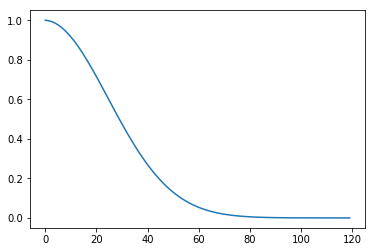

In [124]:
import matplotlib.pyplot as plt
N = 1
factor = []
for i in range(0, 120):
    N = N * np.exp(-i*0.0016)
    factor.append(N)
plt.plot(factor)
plt.show()

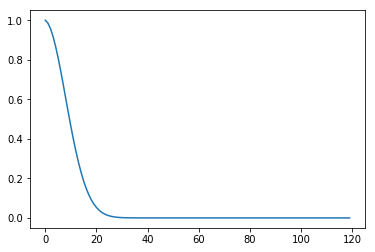

In [219]:
import matplotlib.pyplot as plt
N = 1
factor = []
for i in range(0, 120):
    N = N * np.exp(-i*0.014)
    factor.append(N)
plt.plot(factor)
plt.show()

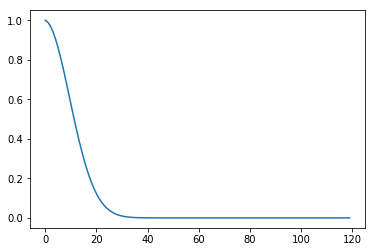

In [54]:
import matplotlib.pyplot as plt
N = 1
factor = []
for i in range(0, 120):
    N = N * np.exp(-i*0.01)
    factor.append(N)
plt.plot(factor)
plt.show()

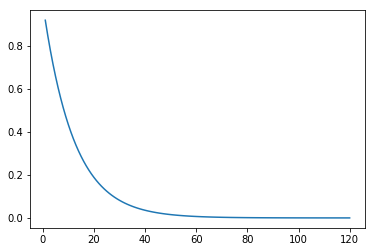

In [108]:
tmax = 120
tau = tmax/10
t = np.linspace(1, tmax, tmax)
plt.plot(t, np.exp(-t/tau))
plt.show()